<a href="https://colab.research.google.com/github/smpark0520/ESAA/blob/main/4_11_%EC%84%B8%EC%85%98_%ED%85%8D%EC%8A%A4%ED%8A%B8%EB%B6%84%EC%84%9D_%EC%97%B0%EC%8A%B5%EB%AC%B8%EC%A0%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **문서 유사도 분석**
* 각 단어를 축으로 하는 특성 공간(feature space)에서 문서들을 하나의 위치로 보고 특성 공간 상에서 거리를 이용해 두 문서의 유사성(similarity)을 측정하는 방식
    * 코사인 유사도(cosine similarity) : 두 벡터 간의 각도의 코사인 값을 이용하여 유사도를 계산, 크기가 아닌 방향성에 중점, 벡터의 길이(문서의 길이)에 영향을 받지 않음

In [30]:
!pip install koreanize-matplotlib

In [31]:
# 필요한 라이브러리를 import하세요.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

## **1. 데이터 로드**

### 서울특별시 다산콜센터(☎120)의 주요 민원
* 서울특별시 다산콜센터(☎120)의 주요 민원(자주 묻는 질문)에 대한 답변정보
* https://opengov.seoul.go.kr/civilappeal/list

In [32]:
df = pd.read_csv("https://bit.ly/seoul-120-text-csv")
df.shape

(2645, 5)

In [33]:
df.head()

,번호,분류,제목,내용,내용번호
0,2645,복지,아빠 육아휴직 장려금,아빠 육아휴직 장려금 업무개요 남성근로자의 육아휴직을 장려하고 양육에 따른 경...,23522464
1,2644,경제,[서울산업진흥원] 서울메이드란?,서울산업진흥원 서울메이드란 서울의 감성을 담은 다양하고 새로운 경험을 제공하기 위해...,23194045
2,2643,환경,(강북구) 정비중,강북구 정비중 업무개요 투명 폐트병을 교환보상하므로 수거율을 높이고 폐기물을 감...,23032485
3,2642,복지,"광진맘택시 운영(임산부,영아 양육가정 전용 택시)",광진맘택시 운영임산부영아 양육가정 전용 택시 업무개요 교통약자인 임산부와 영아가정...,22904492
4,2641,복지,마포 뇌병변장애인 비전센터,마포 뇌병변장애인 비전센터 마포뇌병변장애인 비전센터 운영 구분 내용 목적 학...,22477798


In [34]:
# 중복데이터가 있는지 확인하세요.
df.duplicated()

,0
0,False
1,False
2,False
3,False
4,False
...,...
2640,False
2641,False
2642,False
2643,False


In [35]:
# 결측치를 확인하세요.
df.isnull().sum()

,0
번호,0
분류,0
제목,0
내용,0
내용번호,0


## **2. 벡터화**

* '제목' 열과 '내용' 열을 합친 '제목내용' 열을 만드세요.

In [36]:
df['제목내용'] = df['제목'] + df['내용']

In [37]:
df.head()

,번호,분류,제목,내용,내용번호,제목내용
0,2645,복지,아빠 육아휴직 장려금,아빠 육아휴직 장려금 업무개요 남성근로자의 육아휴직을 장려하고 양육에 따른 경...,23522464,아빠 육아휴직 장려금아빠 육아휴직 장려금 업무개요 남성근로자의 육아휴직을 장려...
1,2644,경제,[서울산업진흥원] 서울메이드란?,서울산업진흥원 서울메이드란 서울의 감성을 담은 다양하고 새로운 경험을 제공하기 위해...,23194045,[서울산업진흥원] 서울메이드란?서울산업진흥원 서울메이드란 서울의 감성을 담은 다양하...
2,2643,환경,(강북구) 정비중,강북구 정비중 업무개요 투명 폐트병을 교환보상하므로 수거율을 높이고 폐기물을 감...,23032485,(강북구) 정비중강북구 정비중 업무개요 투명 폐트병을 교환보상하므로 수거율을 높...
3,2642,복지,"광진맘택시 운영(임산부,영아 양육가정 전용 택시)",광진맘택시 운영임산부영아 양육가정 전용 택시 업무개요 교통약자인 임산부와 영아가정...,22904492,"광진맘택시 운영(임산부,영아 양육가정 전용 택시)광진맘택시 운영임산부영아 양육가정 ..."
4,2641,복지,마포 뇌병변장애인 비전센터,마포 뇌병변장애인 비전센터 마포뇌병변장애인 비전센터 운영 구분 내용 목적 학...,22477798,마포 뇌병변장애인 비전센터마포 뇌병변장애인 비전센터 마포뇌병변장애인 비전센터 운영 ...


* TfidfVectorizer를 이용하여 '제목내용' 열을 피처 벡터화하세요.
  * `tfidf`라는 이름으로 인스턴스를 생성하세요.
  * 'max_features=2000'으로 설정하세요.
  * 변환된 문서 용어 matrix는 `dtm`이라는 변수명으로 저장해주세요.

In [38]:
# '제목내용' 열 피처 벡터화 변환
tfidfvect = TfidfVectorizer(max_features=2000)
dtm = tfidfvect.fit_transform(df['제목내용'])

### 참고: fit, transform, fit_transfrom의 차이점
- fit(): 원시 문서에 있는 모든 토큰의 어휘 사전을 배운다.
- transform(): 문서를 문서 용어 매트릭스로 변환한다. transform 이후엔 매트릭스로 변환되어 숫자형태로 변경된다.
- fit_transform(): 어휘 사전을 배우고 문서 용어 매트릭스를 반환한다. fit 다음에 변환이 오는 것과 동일하지만 더 효율적으로 구현된다.

* API Document: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer.fit_transform

In [39]:
# 문장에서 노출되는 feature(특징이 될만한 단어) 수를 합한 변수 Document Term Matrix(이하 dtm)를 생성합니다.
# 아래 코드를 실행해주세요.
df_dtm_tfidf = pd.DataFrame(dtm.toarray(), columns=tfidfvect.get_feature_names_out())
df_dtm_tfidf.head()

,amp,apos,가격,가구,가구의,가급적,가까운,가꾸기,가능,가능하나,...,회의실,횡단보도,효율적으로,후에,후원,훈련,휴관,휴관일,휴무,희망하는
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.056218,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.113171,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<Axes: >

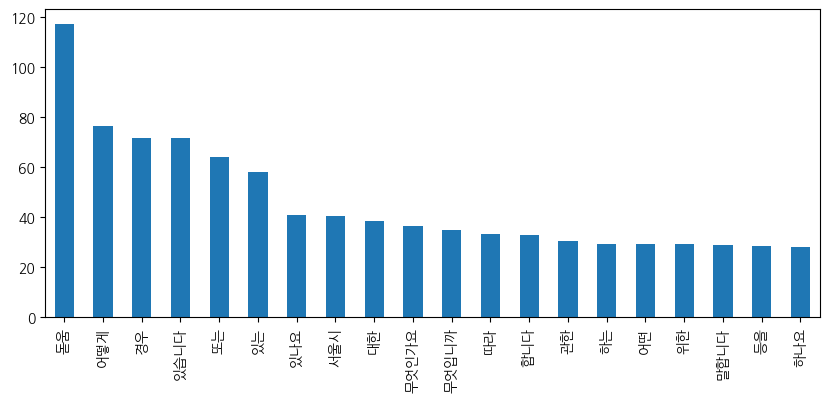

In [40]:
# 각 row에서 전체 단어가방에 있는 어휘에서 등장하는 단어에 대한 가중치를 적용한 vector를 확인합니다.
# 아래 셀을 실행해주세요.
df_dtm_tfidf.sum().nlargest(20).plot(kind="bar", figsize=(10, 4))

## 코사인 유사도


<img src="https://i.imgur.com/RdPPH33.png">
* 이미지 출처 : https://pyimagesearch.com/

<img src="https://storage.googleapis.com/lds-media/images/cosine-similarity-vectors.original.jpg">
* 이미지 출처 : https://www.learndatasci.com/glossary/cosine-similarity/




- 내적 공간 내에서 두 벡터 사이의 코사인 각도를 구하는 방법( –1∼1 사이 값을 가지며, 1에 가까울수록 유사도가 높다.)
- 벡터의 크기가 아닌 방향의 유사도를 판단하는 목적으로 사용되며, 두 벡터의 방향이 완전히 같을 경우 1, 90°의 각을 이룰 경우 0, 180°로 완전히 반대 방향인 경우 -1의 값을 갖음 >> 코사인 유사도에서는 각 데이터 간의 각도가 작을 수록 데이터가 비슷하다.
- 장점: 어떤 개수의 차원에도 적용할 수 있지만 흔히 다차원의 양수 공간에서의 유사도 측정에서 자주 이용한다.
- 단점: 상호 상관관계를 가지는 특성(키, 몸무게 등)를 갖는 원소들간의 유사도를 계산할때에 성능이 낮다.


* 코사인 유사도는 원점(모든 단어의 빈도가 0인 경우)에서 보았을 때 두 문서의 각도에 바탕을 둔 거리 측정 방식이다.
* 내적공간의 두 벡터간 각도의 코사인값을 이용하여 측정된 벡터간의 유사한 정도를 의미한다. 각도가 0°일 때의 코사인값은 1이며, 다른 모든 각도의 코사인값은 1보다 작다. 따라서 이 값은 벡터의 크기가 아닌 방향의 유사도를 판단하는 목적으로 사용되며, 두 벡터의 방향이 완전히 같을 경우 1, 90°의 각을 이룰 경우 0, 180°로 완전히 반대 방향인 경우 -1의 값을 갖는다. 이 때 벡터의 크기는 값에 아무런 영향을 미치지 않는다. 코사인 유사도는 특히 결과값이 [0,1]의 범위로 떨어지는 양수 공간에서 사용된다.
* 코사인 유사도는 어떤 개수의 차원에도 적용이 가능하여 흔히 다차원의 양수 공간에서의 유사도 측정에 자주 이용된다. 예를 들어 정보 검색 및 텍스트 마이닝 분야에서, 단어 하나 하나는 각각의 차원을 구성하고 문서는 각 단어가 문서에 나타나는 회수로 표현되는 벡터값을 가진다. 이러한 다차원 공간에서 코사인 유사도는 두 문서의 유사를 측정하는 매우 유용한 방법이다.
* 코사인 유사도는 데이터 마이닝 분야에서 클러스터들간의 응집도를 측정하는 방법으로도 사용된다.

* 출처: https://ko.wikipedia.org/wiki/%EC%BD%94%EC%82%AC%EC%9D%B8_%EC%9C%A0%EC%82%AC%EB%8F%84
* API Document: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html



$$ \text{{Cosine Similarity}}(A, B) = \frac{{A \cdot B}}{{\|A\|\|B\|}} = \frac{{\sum^n_{i=1}A_iB_i}}{{\sqrt{\sum^n_{i=1}A_i^2}\sqrt{\sum^n_{i=1}B_i^2}}} $$


https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html#sklearn-metrics-pairwise-cosine-similarity

* `sklearn.metrics.pairwise`에서 `cosine_similarity`를 불러온 후 코사인 유사도를 `ndarray` 형태로 반환하세요.
  * 생성된 코사인 유사도 행렬을 `cosine_matrix`라는 변수명으로 저장해주세요.

In [49]:
cosine_matrix = cosine_similarity(df_dtm_tfidf, df_dtm_tfidf)
cosine_matrix

array([[1.        , 0.        , 0.03938162, ..., 0.01994409, 0.        ,
        0.        ],
       [0.        , 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.03938162, 0.        , 1.        , ..., 0.02733107, 0.        ,
        0.        ],
       ...,
       [0.01994409, 0.        , 0.02733107, ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.32093317],
       [0.        , 0.        , 0.        , ..., 0.        , 0.32093317,
        1.        ]])

<Axes: >

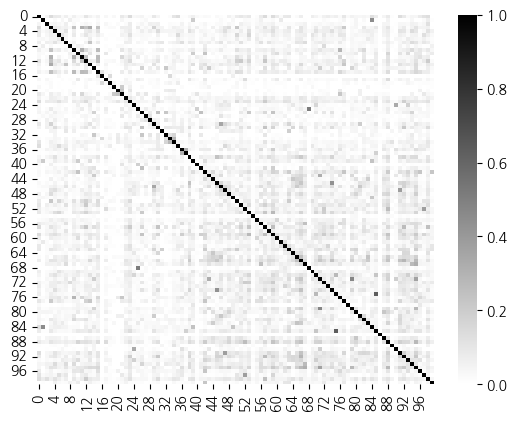

In [42]:
# 코사인 유사도를 시각화합니다.
# 아래 셀을 실행해주세요.
sns.heatmap(cosine_matrix[:100, :100], cmap="gray_r")

## 유사도가 높은 문서

* 첫 번째 행에 대한 코사인 유사도를 'similarity_0'이라는 파생변수로 생성하고 유사도가 높은 순으로 정렬합니다.
  * '번호', '제목', 'similarity_0' 열이 모두 나오게 출력하세요.
  * 제안 : `nlargest(n, columns)` 메소드를 써도 좋습니다.

In [43]:
df['similarity_0'] = cosine_matrix[0]
df.nlargest(10, 'similarity_0')

,번호,분류,제목,내용,내용번호,제목내용,similarity_0
0,2645,복지,아빠 육아휴직 장려금,아빠 육아휴직 장려금 업무개요 남성근로자의 육아휴직을 장려하고 양육에 따른 경...,23522464,아빠 육아휴직 장려금아빠 육아휴직 장려금 업무개요 남성근로자의 육아휴직을 장려...,1.000000
1772,873,경제,도시계획시설부지 재결신청 이후 진행단계는 어떤 과정을 거칩니까?,도시계획시설부지 재결신청 이후 진행단계는 어떤 과정을 거칩니까재결신청 이후 재결신청...,2897109,도시계획시설부지 재결신청 이후 진행단계는 어떤 과정을 거칩니까?도시계획시설부지 재결...,0.213203
1073,1572,경제,부기등기 이후 제한물권 설정의 효력은?,부기등기 이후 제한물권 설정의 효력은 부기등기일 이후에당해 대지 또는 주택을 양수...,2896016,부기등기 이후 제한물권 설정의 효력은?부기등기 이후 제한물권 설정의 효력은 부기등...,0.182378
155,2490,경제,[농업기술센터] 후계농업경영인 선정 및 청년창업형 후계농업경영인 신청 안내,농업기술센터 후계농업경영인 선정 및 청년창업형 후계농업경영인 신청 안내 업무...,2896492,[농업기술센터] 후계농업경영인 선정 및 청년창업형 후계농업경영인 신청 안내농업기술센...,0.179294
539,2106,행정,행려자도 아니고 시설수용자도 아닌 사람이 살고 있던 비닐하우스에서 화상을 입었습니다...,행려자도 아니고 시설수용자도 아닌 사람이 살고 있던 비닐하우스에서 화상을 입었습니다...,2896135,행려자도 아니고 시설수용자도 아닌 사람이 살고 있던 비닐하우스에서 화상을 입었습니다...,0.168208
2252,393,행정,내가 가입되어 있는 보험이 무엇이 있는지 조회할수 있나요?,내가 가입되어 있는 보험이 무엇이 있는지 조회할수 있나요생명보험협회 홈페이지 소비...,2896311,내가 가입되어 있는 보험이 무엇이 있는지 조회할수 있나요?내가 가입되어 있는 보험이...,0.163740
2222,423,복지,장애인을 위한 방송수신기 보급사업,장애인을 위한 방송수신기 보급사업 업무개요 한국방송통신 전파진흥원에서는 방송소...,2897147,장애인을 위한 방송수신기 보급사업장애인을 위한 방송수신기 보급사업 업무개요 한...,0.161021
2095,550,복지,서울수화전문교육원,서울수화전문교육원 업무개요 서울시에서 서울농아인협회에 위탁하여 운영하는 ...,2896931,서울수화전문교육원서울수화전문교육원 업무개요 서울시에서 서울농아인협회에 위...,0.152475
141,2504,경제,[농업기술센터] 도시농업전문가양성교육 신청,농업기술센터 도시농업전문가양성교육 신청 업무개요 도시농업육성 및 지원에 관한 법...,2897619,[농업기술센터] 도시농업전문가양성교육 신청농업기술센터 도시농업전문가양성교육 신청 ...,0.152014
2444,201,경제,중소기업 협동조합 설립신청,중소기업 협동조합 설립신청업무개요 중소기업협동조합사업조합 설립인가를 받고자 할 경우...,2897302,중소기업 협동조합 설립신청중소기업 협동조합 설립신청업무개요 중소기업협동조합사업조합 ...,0.151583


## 유사도가 낮은 문서

* 위와 같은 방법으로 유사도가 낮은 순으로 정렬합니다.
  * 제안 : `nsmallest(n, columns)` 메소드를 써도 좋습니다.

In [44]:
df['similarity_0'] = cosine_matrix[0]
df.nsmallest(10, 'similarity_0')

,번호,분류,제목,내용,내용번호,제목내용,similarity_0
1,2644,경제,[서울산업진흥원] 서울메이드란?,서울산업진흥원 서울메이드란 서울의 감성을 담은 다양하고 새로운 경험을 제공하기 위해...,23194045,[서울산업진흥원] 서울메이드란?서울산업진흥원 서울메이드란 서울의 감성을 담은 다양하...,0.0
16,2629,경제,등록된 법인의 지점이나 사업소는 별도로 등록해야 시공이 가능한가요 ?,등록된 법인의 지점이나 사업소는 별도로 등록해야 시공이 가능한가요 건설산업기본법에서...,16610518,등록된 법인의 지점이나 사업소는 별도로 등록해야 시공이 가능한가요 ?등록된 법인의 ...,0.0
20,2625,경제,ESCO사업의 주요 사업분야에는 어떤게 있나요?,사업의 주요 사업분야에는 어떤게 있나요사업 분야에는 산업체 건물의 소형 열병합 발전...,16610514,ESCO사업의 주요 사업분야에는 어떤게 있나요?사업의 주요 사업분야에는 어떤게 있나...,0.0
31,2614,문화관광,3.1절 나라사랑 기념행사,절 나라사랑 기념행사 용산구 제주년 절 나라사랑 기념행사 기미년 삼월일일 정오 바로...,14564100,3.1절 나라사랑 기념행사절 나라사랑 기념행사 용산구 제주년 절 나라사랑 기념행사 ...,0.0
32,2613,문화관광,궁동체육관 FAQ,궁동체육관 주요 질의사항답 변 사 항궁동체육관 개관일은어떻게 되나요궁동 체육관은 매...,14479825,궁동체육관 FAQ궁동체육관 주요 질의사항답 변 사 항궁동체육관 개관일은어떻게 되나요...,0.0
44,2601,경제,서울 도시농업 사진전,서울 도시농업 사진전업무개요 년 한해 농사를 마무리 하며 서울 도시농업 사진전을 개...,10059785,서울 도시농업 사진전서울 도시농업 사진전업무개요 년 한해 농사를 마무리 하며 서울 ...,0.0
67,2578,복지,찾아가는 청소년 거리상담 서울시연합아웃리치,찾아가는 청소년 거리상담 서울시연합아웃리치 개요 청소년 밀집지역 곳에서 ...,5486919,찾아가는 청소년 거리상담 서울시연합아웃리치찾아가는 청소년 거리상담 서울시연합아웃리치...,0.0
68,2577,경제,태양광 시민펀드,태양광 시민펀드 시민들의 투자금을 모아 태양광 발전소를 짓고 전기를 판매해 수익을 ...,5231608,태양광 시민펀드태양광 시민펀드 시민들의 투자금을 모아 태양광 발전소를 짓고 전기를 ...,0.0
90,2555,환경,동북아 대기질개선 국제 포럼,동북아 대기질개선 국제 포럼업무개요 동북아 대기질 개선 국제 포럼 운영내용 안내 업...,2898273,동북아 대기질개선 국제 포럼동북아 대기질개선 국제 포럼업무개요 동북아 대기질 개선 ...,0.0
99,2546,복지,[건강가정지원센터] 서울가족학교 예비부부교실,건강가정지원센터 서울가족학교 예비부부교실업무개요 우리사회의 심각한 문제로 대두되는 ...,2897754,[건강가정지원센터] 서울가족학교 예비부부교실건강가정지원센터 서울가족학교 예비부부교실...,0.0


### 유사도가 높은 문서 찾는 함수 만들기
* chatGPT, 구글링을 이용하여 하나의 행에 대해 유사도가 높은 문서 순으로 정렬하는 함수를 만들어보세요.

In [47]:
def similarity_n(n):
  df['similarity_n'] = cosine_matrix[n]
  return df.nlargest(10, 'similarity_n')

In [48]:
# 변수를 넣어 점검해보세요.
similarity_n(75)

,번호,분류,제목,내용,내용번호,제목내용,similarity_0,similarity_n
75,2570,행정,친환경급식 안심식재료 지킴이단,친환경급식 안심식재료 지킴이단 업무개요 친환경급식 모니터링 산지체험 활동 ...,3997815,친환경급식 안심식재료 지킴이단친환경급식 안심식재료 지킴이단 업무개요 친환경...,0.063699,1.000000
85,2560,행정,친환경급식 안심식재료 모니터링 체험단,친환경급식 안심식재료 모니터링 체험단 업무개요 학교급식에 사용되는 친환경농...,2898550,친환경급식 안심식재료 모니터링 체험단친환경급식 안심식재료 모니터링 체험단 업...,0.075785,0.634592
70,2575,행정,서울시 친환경 먹거리교육 학부모강사 양성과정 수강생모집,서울시 친환경 먹거리교육 학부모강사 양성과정 수강생모집 업무개요 우리 아이들을...,5028223,서울시 친환경 먹거리교육 학부모강사 양성과정 수강생모집서울시 친환경 먹거리교육 학부...,0.043879,0.273706
2179,466,복지,서울시 함께꿈 학부모단,서울시 함께꿈 학부모단 업무개요 교육수요자인 학부모들의 교육 정책 참여를 ...,2895210,서울시 함께꿈 학부모단서울시 함께꿈 학부모단 업무개요 교육수요자인 학부모들...,0.087066,0.203400
310,2335,건강,"소비자식품위생감시원 및 농,수산물 명예감시원",소비자식품위생감시원 및 농수산물 명예감시원 업무개요 소비자식...,2898049,"소비자식품위생감시원 및 농,수산물 명예감시원소비자식품위생감시원 및 농수산물 명예감시...",0.075085,0.196450
2531,114,문화관광,서울시 생활체육지도자 채용,서울시 생활체육지도자 채용 업무개요 함께 만드는 서울 함께 누리는 서울의 ...,2897256,서울시 생활체육지도자 채용서울시 생활체육지도자 채용 업무개요 함께 만드는 ...,0.120100,0.164932
338,2307,행정,서울시 관련 책자 중 Doing business in Seoul (두잉 비지니스 인...,서울시 관련 책자 중 두잉 비지니스 인 서울 서울글로벌센터서울글로벌빌딩 ...,2895138,서울시 관련 책자 중 Doing business in Seoul (두잉 비지니스 인...,0.084492,0.163288
1623,1022,행정,전술적 계획이란?,전술적 계획이란기획을 반동주의관점에서 바라보며 수단과 단기목표의 선택에 관심을 갖는...,2897271,전술적 계획이란?전술적 계획이란기획을 반동주의관점에서 바라보며 수단과 단기목표의 선...,0.000000,0.152872
1624,1021,행정,조직적 계획이란?,조직적 계획이란기획을 무위주의관점에서 바라보며 수단의 선택에만 관심을 갖는 기획형태...,2897270,조직적 계획이란?조직적 계획이란기획을 무위주의관점에서 바라보며 수단의 선택에만 관심...,0.000000,0.152872
88,2557,환경,꽃 피는 서울상 콘테스트,꽃 피는 서울상 콘테스트 업무개요 서울 꽃으로 피다 캠페인과 관련하여 시민...,2898360,꽃 피는 서울상 콘테스트꽃 피는 서울상 콘테스트 업무개요 서울 꽃으로 피다...,0.082983,0.145484
